In [1]:
%matplotlib inline
import sys
import numpy as np
import math
import pickle
import matplotlib.pyplot as plt
assert (sys.version.startswith('3.6')),"Please use Python 3.6.*"

# Active Learning without Human Intervention - Label Propagation with Graphs

Lizi Chen, lizichen@nyu.edu  

*This script does not use any open-source framework, except necessary numpy.*  
This code is implemented based on [Xiaojin Zhu, Semi-Supervised Learning with Graphs, 2005](http://pages.cs.wisc.edu/~jerryzhu/pub/thesis.pdf)

### TODO:
- Improve the Naive KNN for SoNYC data type
- Use PCA/t-SNE to visualize SoNYC data
- Improve propagation algorithm by just using $F_{U}$
- Understand the Affinity Matrix $\mathbf P$ (need to improve?)
- Cross validaton and tests
- Fine-Tuning for various strategies
- Check corner case, avoid exceptions.


### SoNYC Datasets

In [2]:
def loadSonycData():
    print("** Loading SoNYC datasets **")
    negative_xy = pickle.load(open("../data/negative_xy.pickle", "rb"))
    positive_xy = pickle.load(open("../data/positive_xy.pickle", "rb"))
    X_pool = pickle.load(open("../data/X_pool_10000.pickle", "rb"))
    id_pool = pickle.load(open("../data/id_pool_10000.pickle", "rb"))

    labeled_with_label = np.vstack((positive_xy, negative_xy))
    labels = labeled_with_label[:, 128]
    Mat_Label = np.split(labeled_with_label, [128], axis=1)[0]
    Mat_Unlabel = X_pool

    return Mat_Label, labels, Mat_Unlabel

### Use of Naive KNN (Basic Euclidean distances from one node to other)
We want to see the relationship between one ``query`` datapoint and the rest ``dataset``. 
```
input:
    dataset: the whole dataset N-by-N, where N is the number to total datapoints
            (including labeled and the pool)  
    query: the single data entry 
    k: we value the top K most 'closest' datapoints with the query data entry.
return:
    a list of datapoints(indices) that are the top k most closest to the query data entry.
```

In [3]:
def navie_knn(dataSet, query, k):
    numSamples = dataSet.shape[0]

    ## calculate Euclidean distance between the query entry and the rest datapoints.
    diff = np.tile(query, (numSamples, 1)) - dataSet
    squaredDiff = diff ** 2
    squaredDist = np.sum(squaredDiff, axis=1)  # sum is performed by row

    ## Sort the distance
    sortedDistIndices = np.argsort(squaredDist)
    
    # make sure we have enaough data N greater than the K in this naive KNN
    if k > len(sortedDistIndices): 
        k = len(sortedDistIndices)
        print("***Warning: Not Enough Data points for KNN!***")

    return sortedDistIndices[0:k]

### Build the Affinity Matrix $\mathbf P$
$$\mathbf P = 
\begin{matrix}
p_{11}  &  p_{12}  & \ldots & \ldots & p_{1n}\\
p_{21}  &  p_{22}  & \ldots & \ldots & p_{2n}\\
\vdots  &  \vdots  & \ddots &        & \vdots\\
\vdots  &  \vdots  &        & \ddots & \vdots\\
p_{n1}  &  p_{n2}  &\ldots  & \ldots & p_{nn}
\end{matrix}
\ \text{ ,where } \
p_{ij} = \frac{D_{ij}}{D_{i1} + D_{i2} + \ldots + D_{ik}} = \frac{D_{ij}}{\sum_{k=1}^n D_{ik}}
$$

$p_{ij}$ is the probability of transit from datapoint i to j. 

In [4]:
def buildGraph(MatX, knn_num_neighbors=None):
    num_samples = MatX.shape[0] # number of overall datapoints, including the pool and seeds
    affinity_matrix = np.zeros((num_samples, num_samples), np.float32) # this is the P, square matrix, dim = N * N

    for i in range(num_samples):
        k_neighbors = navie_knn(MatX, MatX[i, :], knn_num_neighbors)
        affinity_matrix[i][k_neighbors] = 1.0 / knn_num_neighbors

    return affinity_matrix 

### Build the Label_Function $\mathbf F (F_{labeled} + F_{unlabeled})$
$$
\begin{matrix}
         & positive & negative \\
data_1   & 1      & 0\\
data_2   & 1      & 0\\
data_3   & 1      & 0\\
\ldots   & \ldots & \ldots\\
data_{301} & 0      & 1\\
data_{302} & 0      & 1\\
data_{303} & 0      & 1\\
\ldots & \ldots   & \ldots\\
data_{N-2} & -1   &  -1\\
data_{N-1} & -1   &  -1\\
data_{N} & -1   &  -1\\
\end{matrix}
\ \text{All the unlabelled datapoints have -1}
$$
```
input: 
    num_samples: number of overall samples, including seeds and pool
    num_classes: 2
    num_label_samples: the number of samples that have already labeled
    clamp_data_label: The real labels, for the num_label_samples labeled datapoints.
output:
    label_function: a N-by-2 matrix
```

In [5]:
def buildLabelFunction(num_samples, num_classes, num_label_samples, clamp_data_label):
    
    label_function = np.zeros((num_samples, num_classes), np.float32)
    # assign the pre-labeled datapoints to the label_function (whole set)
    label_function[0: num_label_samples] = clamp_data_label
    label_function[num_label_samples: num_samples] = -1
    
    return label_function

### Propagaion

In [6]:
def labelPropagation(Mat_Label, Mat_Unlabel, labels, knn_num_neighbors=10, max_iter=500, tolerance=1e-3):

    num_label_samples = Mat_Label.shape[0]
    num_unlabel_samples = Mat_Unlabel.shape[0]
    num_samples = num_label_samples + num_unlabel_samples
    labels_list = np.unique(labels)
    num_classes = len(labels_list)
    
    # vertically stack all the 128-embedding
    MatX = np.vstack((Mat_Label, Mat_Unlabel))
    
    # clamp_data_label copies labels from the pre-labeled datapoints
    # for binary classification: 
    #    dim = num_label_samples * 2
    clamp_data_label = np.zeros((num_label_samples, num_classes), np.float32)
    for i in range(num_label_samples):
        clamp_data_label[i][labels[i]] = 1.0

    # get the label_function!!
    label_function = buildLabelFunction(num_samples, num_classes, num_label_samples, clamp_data_label)

    # graph construction
    affinity_matrix = buildGraph(MatX, knn_num_neighbors)

    iter = 0;
    # pre_label_function - dummy place holder for label_function - update after each iteration
    pre_label_function = np.zeros((num_samples, num_classes), np.float32) 
    # each iteration we try to minimize the label_function
    convergence = np.abs(pre_label_function - label_function).sum() 
    
    convergence_arr = []
    
    # ending criteria: 
    while iter < max_iter and convergence > tolerance:
        if iter % 1 == 0:
#             print("---> Iteration %d/%d, convergence: %f" % (iter, max_iter, convergence))
            convergence_arr.append(convergence)
            
        pre_label_function = label_function
        iter += 1

        # the propagation step:
        label_function = np.dot(affinity_matrix, label_function)

        # clamp back on the true labels that were manually assigned.
        # TODO:
        # we want to calculate entropy at this point and give manual input!!! (For a faster convergence!)
        # [Is it necessary though?]
        label_function[0: num_label_samples] = clamp_data_label

        # check converge
        convergence = np.abs(pre_label_function - label_function).sum()

    # get terminate label of unlabeled data
    unlabel_data_labels = np.zeros(num_unlabel_samples)
    for i in range(num_unlabel_samples):
        unlabel_data_labels[i] = np.argmax(label_function[i + num_label_samples])

    # plot a convergence graph
    plt.plot(convergence_arr)
    plt.xlabel("Iteration")
    plt.ylabel("Label Convergence")
    plt.title("Change of Label_Functions throughout Iterations")
        
    return unlabel_data_labels

### Run the Test!

In [7]:
number_of_neighbors_to_care_for = 10
maximum_prop_iteration = 400
least_tolerance = 1e-4

** Loading SoNYC datasets **
shape of Mat_Label:(600, 128)
length of labels:600
shape of Mat_Unlabel:(9974, 128)


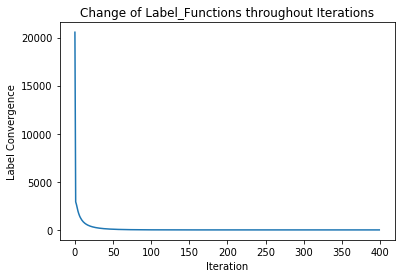

In [8]:
Mat_Label, labels, Mat_Unlabel = loadSonycData() 

print("shape of Mat_Label:"+str(Mat_Label.shape))
print("length of labels:"+str(len(labels)))
print("shape of Mat_Unlabel:"+str(Mat_Unlabel.shape))

unlabel_data_labels = labelPropagation(Mat_Label, 
                                       Mat_Unlabel, 
                                       labels, 
                                       knn_num_neighbors=number_of_neighbors_to_care_for, 
                                       max_iter=maximum_prop_iteration,
                                       tolerance = least_tolerance)

### Show the labels! (From X_pool,pickle)

In [35]:
# TODO: not cool to take extra memory
id_pool = pickle.load(open("../data/id_pool_10000.pickle", "rb"))

for index, l in np.ndenumerate(unlabel_data_labels):
    sensor_and_timestamp = id_pool[index][0].decode('UTF-8')
    audio_slot = id_pool[index][1].decode('UTF-8')
    estimated_label = int(l)
#     print('Entry %4d in X_pool is labeled as %d' % (index[0],int(l)))
    print('%3d. %27s at %s is labelled as %d' % (index[0], sensor_and_timestamp, audio_slot, estimated_label))

  0.  b827eb2a1bce_1493161974.47 at 9 is labelled as 0
  1.  b827eb44506f_1497582712.61 at 2 is labelled as 0
  2.  b827eb820cfe_1493761878.87 at 1 is labelled as 1
  3.  b827eb2a1bce_1484757851.62 at 2 is labelled as 1
  4.  b827eb4e7821_1484186859.83 at 3 is labelled as 1
  5.   b827eb44506f_1486339452.1 at 0 is labelled as 1
  6.  b827eb73e772_1499707658.51 at 2 is labelled as 1
  7.  b827eb7b2c3e_1486014609.07 at 5 is labelled as 0
  8.  b827eb132382_1495855204.51 at 9 is labelled as 1
  9.  b827eb9d0e7f_1492770298.55 at 3 is labelled as 1
 10.  b827eb5895e9_1490591966.24 at 6 is labelled as 0
 11.  b827eb29eb77_1493877015.27 at 0 is labelled as 0
 12.  b827eb86d458_1486595683.82 at 1 is labelled as 0
 13.  b827eb0d8af7_1489976712.64 at 4 is labelled as 1
 14.  b827eb0d8af7_1494011435.49 at 1 is labelled as 1
 15.  b827eb32f75c_1493353630.01 at 7 is labelled as 1
 16.  b827eb5895e9_1500149152.86 at 4 is labelled as 1
 17.  b827eb815321_1489409708.42 at 2 is labelled as 1
 18.  b827

3836.  b827eb0fedda_1483380190.78 at 4 is labelled as 1
3837.  b827eb42bd4a_1489306191.79 at 5 is labelled as 1
3838.  b827eb86d458_1497973137.54 at 1 is labelled as 0
3839.   b827eb7b2c3e_1488396819.7 at 1 is labelled as 0
3840.  b827eb44506f_1495300467.34 at 9 is labelled as 1
3841.   b827eb9bed23_1484440234.9 at 8 is labelled as 1
3842.  b827ebdd5c38_1495815570.92 at 8 is labelled as 1
3843.   b827eb539980_1490313639.5 at 4 is labelled as 0
3844.  b827ebdd5c38_1480812759.16 at 6 is labelled as 0
3845.  b827eb2c65db_1500334900.01 at 4 is labelled as 1
3846.  b827eb0d8af7_1494346087.36 at 1 is labelled as 1
3847.  b827eb815321_1486100004.57 at 9 is labelled as 1
3848.  b827eb815321_1479186407.11 at 4 is labelled as 1
3849.  b827eb252949_1491183244.76 at 7 is labelled as 1
3850.   b827eb44506f_1500128437.3 at 2 is labelled as 0
3851.  b827eb9bed23_1484439528.21 at 6 is labelled as 1
3852.  b827ebad073b_1492205198.61 at 3 is labelled as 1
3853.  b827eb815321_1479108409.78 at 6 is labell

7835.  b827eb122f0f_1481056784.09 at 3 is labelled as 1
7836.  b827eb0fedda_1486715565.41 at 7 is labelled as 0
7837.  b827eb5895e9_1484271727.87 at 2 is labelled as 0
7838.  b827ebdd5c38_1487184155.21 at 5 is labelled as 0
7839.  b827eb0fedda_1483305660.85 at 1 is labelled as 0
7840.  b827eb2a1bce_1481679738.64 at 2 is labelled as 0
7841.  b827eb252949_1499556128.15 at 8 is labelled as 0
7842.  b827eb86d458_1488294521.92 at 3 is labelled as 0
7843.  b827ebba613d_1490198099.82 at 6 is labelled as 0
7844.  b827eb9bed23_1490459660.82 at 7 is labelled as 0
7845.  b827eb132382_1482768840.32 at 8 is labelled as 0
7846.  b827eb5895e9_1483539643.56 at 8 is labelled as 0
7847.  b827eb4e7821_1485868978.96 at 5 is labelled as 0
7848.  b827eb905497_1497730885.67 at 8 is labelled as 0
7849.  b827eb3bda47_1495931479.94 at 8 is labelled as 0
7850.  b827eb9bed23_1497083909.42 at 0 is labelled as 0
7851.  b827eb44506f_1493776848.31 at 2 is labelled as 0
7852.  b827eb9bed23_1484600147.44 at 5 is labell